In [45]:
import pyFAI
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import fabio
import pyFAI.gui
import pyFAI.detectors
import pyFAI.calibrant
from pyFAI.gui import jupyter
import silx
import pygix
import math
import pandas as pd
import os

print("Using pyFAI version",pyFAI.version)

Using pyFAI version 0.21.3


<AxesSubplot:>

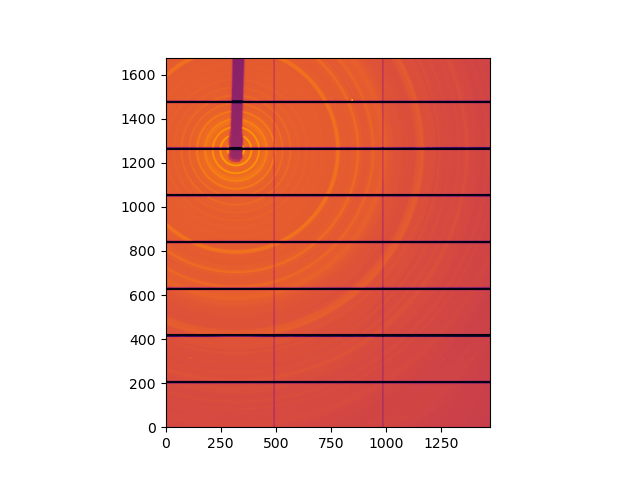

In [33]:
%matplotlib widget
calib_path ='/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/AgB_Calibration/'

from pyFAI.gui import jupyter
img = fabio.open(path+'AgB_2022_06_29_tiled_hi_2m.edf').data
jupyter.display(img)

"tiled_hi" calibration

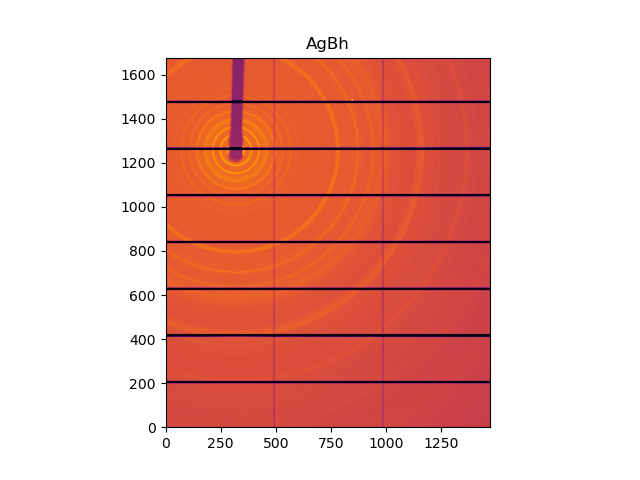

In [8]:
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.gui.jupyter.calib import Calibration

path ='/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/AgB_Calibration/'

#initialize parameters
wavelength = 1.2398e-10
pilatus = pyFAI.detector_factory('Pilatus2M')
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength=wavelength

#load test data
img = fabio.open(path+'AgB_2022_06_29_tiled_hi_2m.edf').data
jupyter.display(img,label = "AgBh")

#display calibration widget
calib = Calibration(img, calibrant=AgBh, wavelength=wavelength, detector=pilatus)

In [9]:
gr = calib.geoRef
print(gr)
print(calib.fixed)
print(gr.chi2())

Detector Pilatus 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.239800e-10m
SampleDetDist= 2.839378e-01m	PONI= 2.215105e-01, 5.561729e-02m	rot1=0.003808  rot2= -0.018640  rot3= 0.000000 rad
DirectBeamDist= 283.989mm	Center: x=317.070, y=1257.076 pix	Tilt=1.090 deg  tiltPlanRotation= -101.545 deg
['wavelength', 'rot3']
2.204796356191519e-05


In [11]:
gr.rot1=gr.rot2=gr.rot3=0
gr.refine3(fix=['wavelength'])
print(gr.chi2())
print(gr)
gr.save('calibration_hi_jupyter.poni')

2.205428817133597e-05
Detector Pilatus 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.239800e-10m
SampleDetDist= 2.839347e-01m	PONI= 2.207199e-01, 5.657846e-02m	rot1=0.007165  rot2= -0.015884  rot3= -0.000000 rad
DirectBeamDist= 283.978mm	Center: x=317.116, y=1257.032 pix	Tilt=0.998 deg  tiltPlanRotation= -114.278 deg


In [42]:
ai = pyFAI.load(gr)

In [14]:
res1 = ai.integrate1d(img, 1000)
res2 = ai.integrate2d(img, 1000)


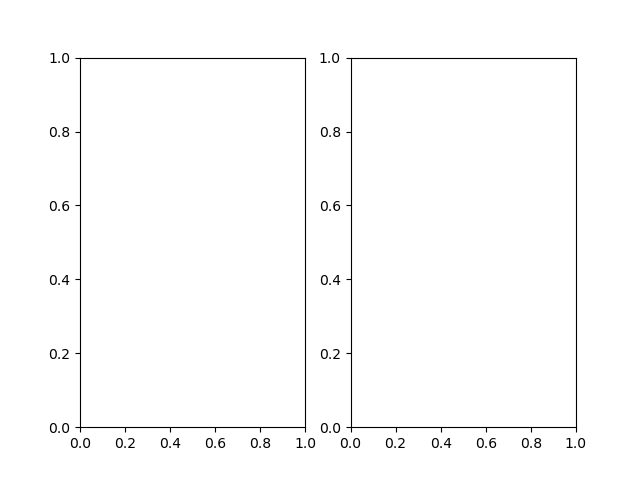

In [30]:
from matplotlib.pyplot import subplots
fig, (ax1, ax2) = subplots(1, 2)



In [31]:
jupyter.plot1d(res1, ax=ax1, calibrant=AgBh)
jupyter.plot2d(res2, ax=ax2, calibrant=AgBh)
ax2.set_title('2D cake')
plt.tight_layout()

In [44]:
sam_path = '/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/TC/'
sam = fabio.open(sam_path + 'TC_7PM7_A0p110_30s_hi_2m.edf').data
pg = pygix.Transform()
pg.load(calib_path + 'calibration_hi_jupyter.poni')
pg.sample_orientation = 3
pg.incident_angle = 0.14
print(pg)
sam_rec, qxy, qz = pg.transform_reciprocal(sam,
                                          method='bbox',
                                          )
plot.imshow(sam_rec, 
            extent=(np.min(qxy),np.max(qxy),np.min(qz),np.max(qz)),
            origin = "lower",
            interpolation='spline16')

Detector Pilatus 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.239800e-10m
SampleDetDist= 2.839347e-01m	PONI= 2.207199e-01, 5.657846e-02m	rot1=0.007165  rot2= -0.015884  rot3= -0.000000 rad
DirectBeamDist= 283.978mm	Center: x=317.116, y=1257.032 pix	Tilt=0.998 deg  tiltPlanRotation= -114.278 deg


AttributeError: type object 'dict' has no attribute 'popn'

In [ ]:
sam_path = '/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/TC/'
img = fabio.open(sam_path + 'TC_7PM7_A0p110_30s_hi_2m.edf')
img.fabio